<IMG SRC="https://raw.githubusercontent.com/pastas/pastas/master/doc/_static/logo.png" WIDTH=250 ALIGN="right">

# Example 1: Pastas Cookbook recipe
***

This notebook is supplementary material to the following article in Groundwater:

*Collenteur, R.A., Bakker, M., Caljé, R., Klop, S.A. and Schaars, F. (2019), Pastas: Open Source Software for the Analysis of Groundwater Time Series. Groundwater, 57: 877-885. [doi:10.1111/gwat.12925](https://ngwa.onlinelibrary.wiley.com/doi/full/10.1111/gwat.12925)*

**Please note that the numbers and figures in this Notebook may slightly differ from those in the original publication due to some minor improvements/changes in the software code.**
    
In this notebook the Pastas "cookbook" recipe is shown. In this example it is investigated how well the heads measured in a borehole near Kingstown, Rhode Island, US, can be simulated using rainfall and potential evaporation. A transfer function noise (TFN) model using impulse response function is created to simulate the observed heads.

The observed heads are obtained from the Ground-Water Climate Response Network (CRN) of the USGS (https://groundwaterwatch.usgs.gov/). The corresponding USGS site id is 412918071321001. The rainfall data is taken from the Global Summary of the Day dataset (GSOD) available at the National Climatic Data Center (NCDC). The rainfall series is obtained from the weather station in Kingston (station number: NCDC WBAN 54796) located at  41.491$^\circ$, -71.541$^\circ$. The evaporation is calculated from the mean temperature obtained from the same USGS station using Thornthwaite's method (Pereira and Pruitt, 2004).

*Pereira AR, Pruitt WO (2004),  Adaptation of the Thornthwaite scheme for estimating daily reference evapotranspiration, Agricultural Water Management 66(3), 251-257*

### Step 1. Importing the python packages
The first step to creating the TFN model is to import the python packages. In this notebook two packages are used, the Pastas package and the Pandas package to import the time series data. Both packages are short aliases for convenience (`ps` for the Pastas package and `pd` for the Pandas package). The other packages that are imported are not needed for the analysis but are needed to make the publication figures.

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import pastas as ps

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.19.2
Scipy version: 1.6.0
Pandas version: 1.2.1
Pastas version: 0.17.0b
Matplotlib version: 3.3.2


### Step 2. Reading the time series
The next step is to import the time series data. Three series are used in this example; the observed groundwater head, the rainfall and the evaporation. The data can be read using different methods, in this case the Pandas `read_csv` method is used to read the csv files. Each file consists of two columns; a date column called 'Date' and a column containing the values for the time series. The index column is the first column and is read as a date format. The heads series are stored in the variable `obs`, the rainfall in `rain` and the evaporation in `evap`. All variables are transformed to SI-units.

In [2]:
obs = pd.read_csv('obs.csv', index_col='Date', parse_dates=True, squeeze=True) * 0.3048
rain = pd.read_csv('rain.csv', index_col='Date', parse_dates=True, squeeze=True) * 0.3048
rain = rain.asfreq("D", fill_value=0.0) # There are some nan-values present
evap = pd.read_csv('evap.csv', index_col='Date', parse_dates=True, squeeze=True) * 0.3048

### Step 3. Creating the model
After reading in the time series, a Pastas Model instance can be created, `Model`. The `Model` instance is stored in the variable `ml` and takes two input arguments; the head time series `obs`, and a model name: "Kingstown".

In [3]:
ml = ps.Model(obs.loc[::14], name='Kingstown')

### Step 4. Adding stress models
A `RechargeModel` instance is created and stored in the variable `rm`, taking the rainfall and potential evaporation time series as input arguments, as well as a name and a response function. In this example the Gamma response function is used (the Gamma function is available as `ps.Gamma`). After creation the recharge stress model instance is added to the model. 

In [4]:
rm = ps.RechargeModel(rain, evap, name='recharge', rfunc=ps.Gamma)
ml.add_stressmodel(rm)

### Step 5. Solving the model
The model parameters are estimated by calling the `solve` method of the `Model` instance. In this case the default settings are used (for all but the tmax argument) to solve the model. Several options can be specified in the `.solve` method, for example; a `tmin` and `tmax` or the type of solver used (this defaults to a least squares solver, `ps.LeastSquares`). This `solve` method prints a fit report with basic information about the model setup and the results of the model fit.

In [5]:
ml.solve(tmax="2014");

# Print some information on the model fit for the validation period
print("\nThe R2 and the RMSE in the validation period are ", ml.stats.rsq(tmin="2015", tmax="2019").round(2), 
      "and", ml.stats.rmse(tmin="2015", tmax="2019").round(2), ", respectively.")

Fit report Kingstown               Fit Statistics
nfev    21                     EVP           88.81
nobs    281                    R2             0.89
noise   1                      RMSE           0.12
tmin    2003-01-01 00:00:00    AIC           56.80
tmax    2014-01-01 00:00:00    BIC           78.63
freq    D                      Obj            0.58
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                optimal   stderr    initial  vary
recharge_A   317.949672   ±5.18%  98.181587  True
recharge_n     1.314105   ±1.81%   1.000000  True
recharge_a    56.521104   ±5.77%  10.000000  True
recharge_f    -0.670920   ±8.09%  -1.000000  True
constant_d    -4.389317   ±1.43%  -3.578965  True
noise_alpha   83.339732  ±19.75%  14.000000  True

The R2 and the RMSE in the validation period are  0.84 and 0.14 , respectively.


### Step 6. Visualizing the results
The final step of the "cookbook" recipe is to visualize the results of the TFN model. The Pastas package has several build in plotting methods, available through the `ml.plots` instance. Here the `.results` plotting method is used. This method plots an overview of the model results, including the simulation and the observations of the groundwater head, the optimized model parameters, the residuals and the noise, the contribution of each stressmodel, and the step response function for each stressmodel. 

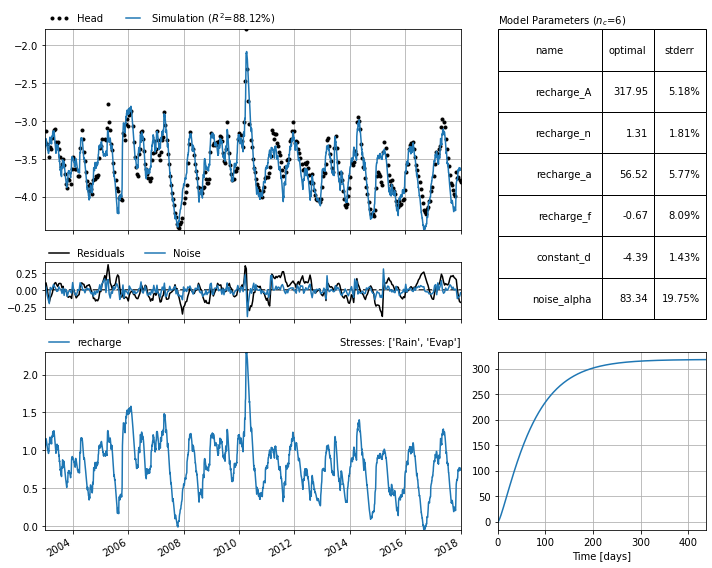

In [6]:
ml.plots.results(tmax="2018");

### 7. Diagnosing the noise series
The `diagnostics` plot can be used to interpret how well the noise follows a normal distribution and suffers from autocorrelation (or not).

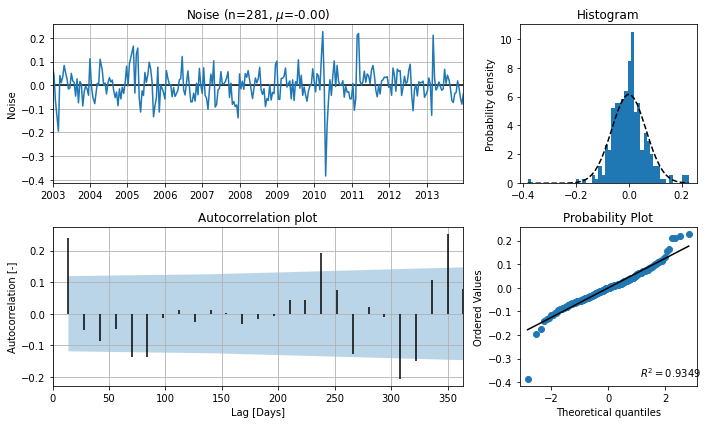

In [7]:
ml.plots.diagnostics();

# Make plots for publication
In the next codeblocks the Figures used in the Pastas paper are created. The following figures are created:

- Figure of the impulse and step respons for the scaled Gamma response function
- Figure of the stresses used in the model
- Figure of the modelfit and the step response
- Figure of the model fit as returned by Pastas
- Figure of the model residuals and noise
- Figure of the Autocorrelation function

### Make a plot of the impulse and step response for the Gamma and Hantush functions

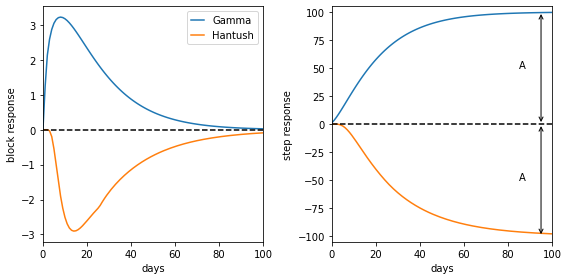

In [8]:
rfunc = ps.Gamma(cutoff=0.999)
p = [100, 1.5, 15]
b = np.append(0, rfunc.block(p))
s = rfunc.step(p)

rfunc2 = ps.Hantush(cutoff=0.999)
p2 = [-100, 30, 0.7]
b2 = np.append(0, rfunc2.block(p2))
s2 = rfunc2.step(p2)

# Make a figure of the step and block response
fig, [ax1, ax2] = plt.subplots(1, 2, sharex=True, figsize=(8, 4))
ax1.plot(b)
ax1.plot(b2)
ax1.set_ylabel("block response")
ax1.set_xlabel("days")
ax1.legend(["Gamma", "Hantush"], handlelength=1.3)
ax1.axhline(0.0, linestyle="--", c="k")

ax2.plot(s)
ax2.plot(s2)
ax2.set_xlim(0,100)
ax2.set_ylim(-105, 105)
ax2.set_ylabel("step response")
ax2.set_xlabel("days")
ax2.axhline(0.0, linestyle="--", c="k")
ax2.annotate('', xy=(95, 100), xytext=(95, 0),
             arrowprops={'arrowstyle': '<->'})
ax2.annotate('A', xy=(95, 100), xytext=(85, 50))
ax2.annotate('', xy=(95, -100), xytext=(95, 0),
             arrowprops={'arrowstyle': '<->'})
ax2.annotate('A', xy=(95, 100), xytext=(85, -50))
plt.tight_layout()

### Make a plot of the stresses used in the model

Text(0.5, 0, 'year')

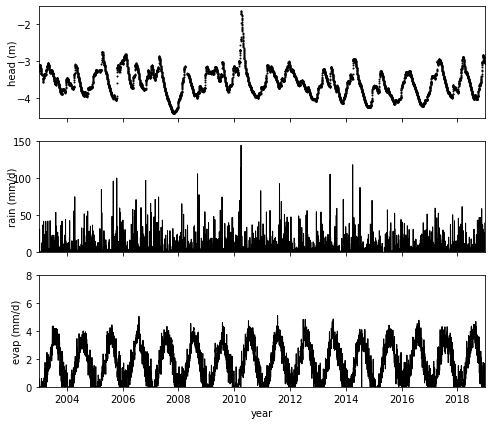

In [9]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1, sharex=True, figsize=(8, 7))

ax1.plot(obs, 'k.',label='obs', markersize=2)
ax1.set_ylabel('head (m)', labelpad=0)
ax1.set_yticks([-4, -3, -2])

plot_rain = ax2.plot(rain * 1000, color='k', label='prec', linewidth=1)
ax2.set_ylabel('rain (mm/d)', labelpad=-5)
ax2.set_xlabel('Date');
ax2.set_ylim([0,150])
ax2.set_yticks(np.arange(0, 151, 50))

plot_evap = ax3.plot(evap * 1000,'k', label='evap', linewidth=1)
ax3.set_ylabel('evap (mm/d)')
ax3.tick_params('y')
ax3.set_ylim([0,8])

plt.xlim([pd.Timestamp('2003'), pd.Timestamp('2019')])
ax2.set_xlabel("")
ax3.set_xlabel("year")

### Make a custom figure of the model fit and the estimated step response

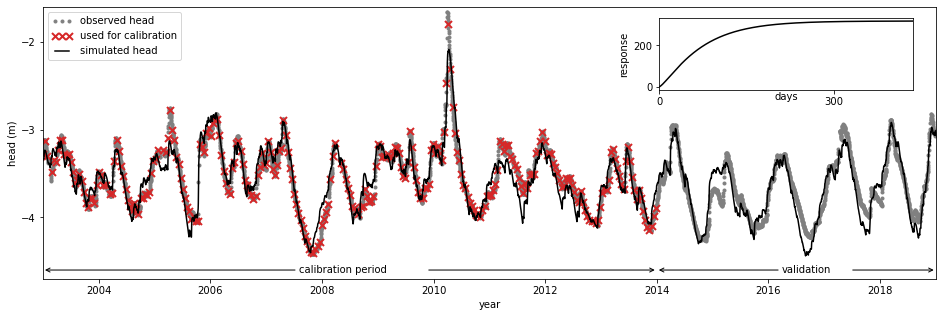

In [10]:
# Create the main plot
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(obs, marker=".", c="grey", linestyle=" ")
ax.plot(obs.loc[:"2013":14], marker="x", markersize=7, c="C3", linestyle=" ", mew=2)
ax.plot(ml.simulate(tmax="2019"), c="k")
plt.ylabel('head (m)')
plt.xlabel('year')
plt.title("")
plt.xlim(pd.Timestamp('2003'), pd.Timestamp('2019'))
plt.ylim(-4.7, -1.6)
plt.yticks(np.arange(-4, -1, 1))

# Create the arrows indicating the calibration and validation period
ax.annotate("calibration period", xy=(pd.Timestamp("2003-01-01"), -4.6), xycoords='data',
            xytext=(300, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), va="center", ha="center")
ax.annotate("", xy=(pd.Timestamp("2014-01-01"), -4.6), xycoords='data',
            xytext=(-230, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), va="center", ha="center")

ax.annotate("validation", xy=(pd.Timestamp("2014-01-01"), -4.6), xycoords='data',
            xytext=(150, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), va="center", ha="center")
ax.annotate("", xy=(pd.Timestamp("2019-01-01"), -4.6), xycoords='data',
            xytext=(-85, 0), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), va="center", ha="center")

plt.legend(["observed head", "used for calibration","simulated head"], loc=2, numpoints=3)

# Create the inset plot with the step response
ax2 = plt.axes([0.66, 0.65, 0.22, 0.2])
s = ml.get_step_response("recharge")
ax2.plot(s, c="k")
ax2.set_ylabel("response")
ax2.set_xlabel("days", labelpad=-15)
ax2.set_xlim(0, s.index.size)
ax2.set_xticks([0, 300])

### Make a figure of the fit report

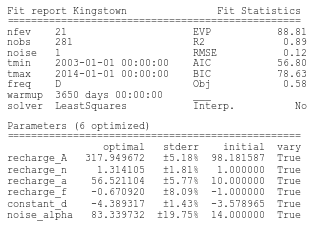

In [11]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
#font.set_size(10)
font.set_weight('normal')
font.set_family('monospace')
font.set_name("courier new")

plt.text(-1, -1, str(ml.fit_report()), fontproperties=font)
plt.axis('off')
plt.tight_layout()

### Make a Figure of the noise, residuals and autocorrelation

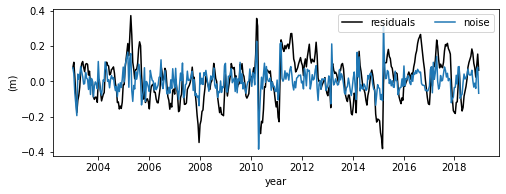

In [12]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 3))
ml.residuals(tmax="2019").plot(ax=ax1, c="k")
ml.noise(tmax="2019").plot(ax=ax1, c="C0")
plt.xticks(rotation=0, horizontalalignment='center')
ax1.set_ylabel('(m)')
ax1.set_xlabel('year')
ax1.legend(["residuals", "noise"], ncol=2)

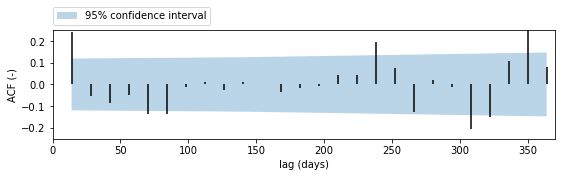

In [13]:
ax = ps.stats.plot_acf(ml.noise(), figsize=(9, 2))
ax.set_ylabel('ACF (-)')
ax.set_xlabel('lag (days)')
plt.legend(["95% confidence interval"], loc=(0.0, 1.05))
plt.xlim(0, 370)
plt.ylim(-0.25, 0.25)
plt.title("")
plt.grid()

In [14]:
ml.stats.diagnostics()

,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,0.94,0.00,True
D'Agostino,Normality,43.26,0.00,True
Runs test,Autocorr.,-3.76,0.00,True
Stoffer-Toloi,Autocorr.,32.27,0.00,True


In [15]:
q, p = ps.stats.stoffer_toloi(ml.noise())
print("The hypothesis that there is significant autocorrelation is:", p)

The hypothesis that there is significant autocorrelation is: 2.804483035681447e-06
